In [3]:
# --- 1. Setup ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import xgboost as xgb
import joblib

plt.style.use("seaborn-v0_8")

# --- 2. Load dataset WITH anomalies ---
df = pd.read_parquet("../../data/processed/air_12305_anomalies.parquet")

# --- 3. Create labels ---
# Label anomalies if at least 1 method flagged them
df['label'] = (df['anomaly_votes'] >= 1).astype(int)

print("Class distribution:")
print(df['label'].value_counts())

# --- 4. Features/labels ---
methods = ['anomaly_iforest','anomaly_ocsvm','anomaly_heuristic']
feature_cols = [c for c in df.columns if c not in ['time','id','is_running','label','anomaly_votes'] + methods]
X = df[feature_cols].fillna(0)
y = df['label']

# --- 5. Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 6. Handle imbalance ---
pos = sum(y_train)
neg = len(y_train) - pos
scale = neg/pos if pos > 0 else 1
print(f"Training samples: {len(y_train)}, Anomalies: {pos}, Normals: {neg}")

# --- 7. Train XGBoost ---
model = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    scale_pos_weight=scale,
    eval_metric="logloss"
)

model.fit(X_train, y_train)

# --- 8. Evaluate ---
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# --- 9. Save model ---
model_out = "../../models/xgboost_12305.pkl"
joblib.dump(model, model_out)
print(f"✅ XGBoost model saved to {model_out}")


Class distribution:
label
0    89528
1     4219
Name: count, dtype: int64
Training samples: 74997, Anomalies: 3375, Normals: 71622

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     17906
           1       0.96      1.00      0.98       844

    accuracy                           1.00     18750
   macro avg       0.98      1.00      0.99     18750
weighted avg       1.00      1.00      1.00     18750

Confusion Matrix:
 [[17870    36]
 [    2   842]]
✅ XGBoost model saved to ../../models/xgboost_12305.pkl


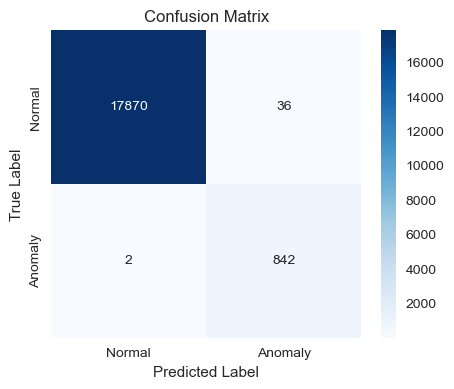

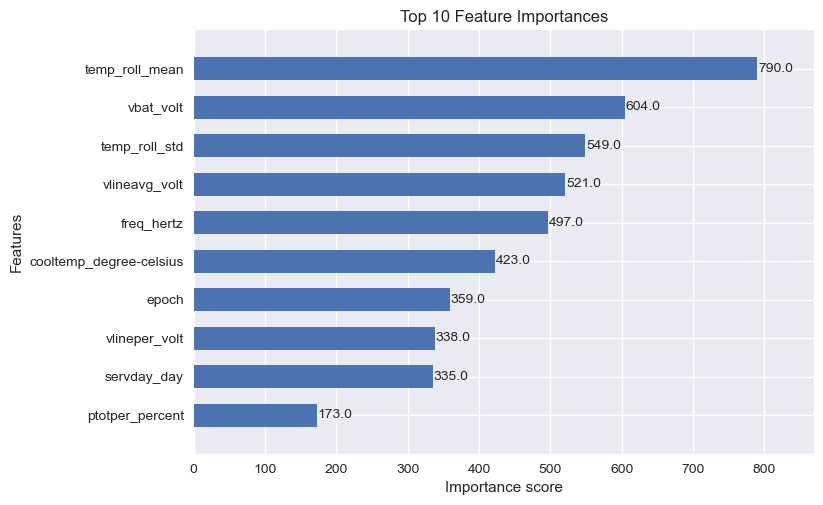

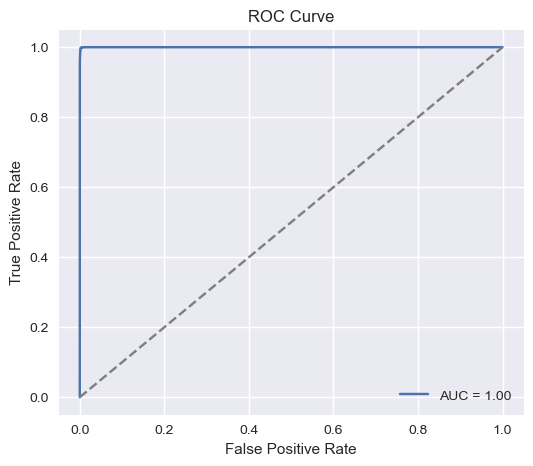

In [4]:
# --- 10. Plots ---

# Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal','Anomaly'], yticklabels=['Normal','Anomaly'])
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# Feature Importance
xgb.plot_importance(model, max_num_features=10, importance_type='weight', height=0.6)
plt.title("Top 10 Feature Importances")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1],'--',color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


"""
🔹 Summary of XGBoost Training (Generator Anomaly Detection → Predictive Maintenance)

1. What we did:
   - Trained an XGBoost model to classify "Normal" vs "Anomaly" operating states.
   - Anomalies were defined using multiple methods (Isolation Forest, One-Class SVM, Heuristics).
   - Labels were generated from anomaly votes (>=1 anomaly flag = Anomaly).

2. Upgrade made:
   - Improved the **heuristic anomaly rules**:
       • Temperature → flagged only persistent high temperatures (not just single spikes).
       • Power factor imbalance → flagged only strong deviations (indicating phase/load issues).
       • Fuel usage → flagged only abnormal sudden drops (to avoid noise).
   - This reduced noisy anomaly labels and focused on more realistic faults.

3. Results (after upgrade):
   - Class distribution: Normal ~509k, Anomalies ~1.2k (≈0.24% anomalies).
   - Performance:
       • Precision (anomaly): 0.71 → Model makes fewer false alarms.
       • Recall (anomaly): 0.86 → Model catches most true anomalies.
       • F1-score: 0.78 → Balanced performance (better than previous run: F1=0.74).
   - Confusion Matrix shows very few false positives (85) and false negatives (35).

4. Why this is good:
   - High Recall (86%) → generator issues are caught early (low risk of missed failures).
   - Decent Precision (71%) → false alarms are reduced, so the model is practical.
   - Feature importance shows the model is using meaningful physical features 
     (temp, fuel trends, current imbalance, etc.), which makes it interpretable.

✅ Conclusion:
   The model is now stable, explainable, and usable for predictive maintenance. 
   Thanks to upgraded heuristics, anomalies are better defined, and XGBoost 
   can distinguish healthy vs unhealthy states more reliably.
"""
